# Optimisation: First example

This example shows you how to run a global optimisation with Pints.

First, we import pints:

In [1]:
import pints

Next, we need a model: any class that implements the [pints.ForwardModel interface](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#forward-model).

Usually, you'd write a class for this purpose (that wrapped around whatever simulation package you wanted to use to generate your time series data). But you could also use a pure-Python model.

In the example, we use a [logistic model](https://en.wikipedia.org/wiki/Logistic_function), provided by [Pints's toy model module](http://pints.readthedocs.io/en/latest/toy/index.html).

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

This model has two parameters: A growth rate (which determines the steepness of the curve) and a carrying capacity (which determines the number the curve converges to).
For the example, we simply pick some nice values:

In [3]:
real_parameters = [0.015, 500]

Finally, we create a list of times (in a real experiment, these would be the times at which the time series was sampled)

In [4]:
import numpy as np
times = np.linspace(0, 1000, 1000)

We now have everything we need to run a simulation and generate some toy data:

In [5]:
values = model.simulate(real_parameters, times)

We can use Matplotlib (or any other plotting package) to have a look at the generated data:

In [6]:
import matplotlib.pyplot as plt

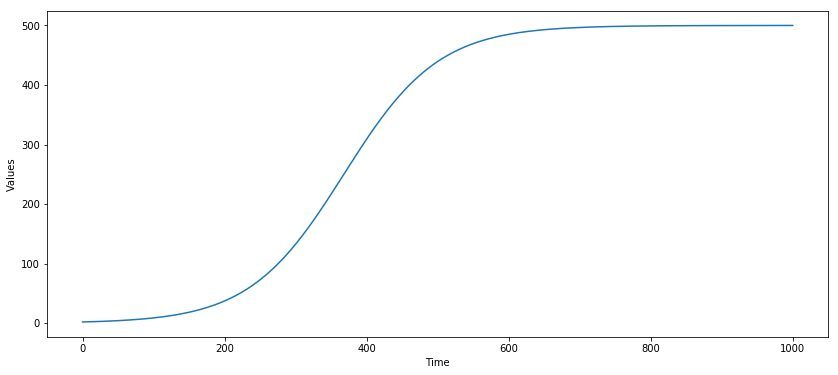

In [7]:
plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values)
plt.show()

If you like, you can make it more realistic at this point by adding some noise:

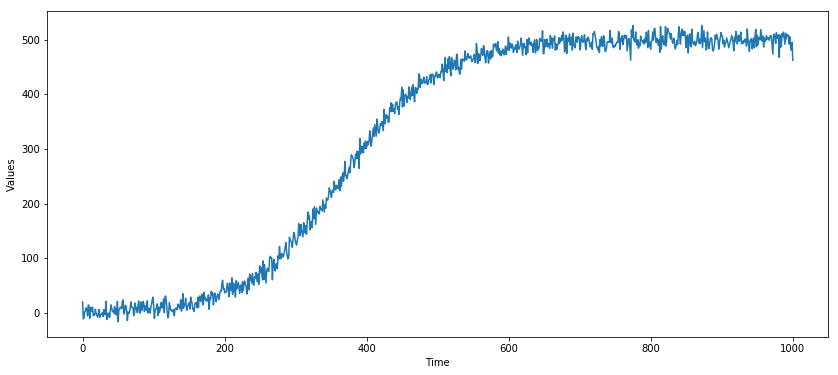

In [8]:
values += np.random.normal(size=values.shape) * 10

plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values)
plt.show()

We now set up an optimisation, to see if we can recover our original parameters from this data.

First, we define a problem (in this case a [single-valued time series fitting problem](https://pints.readthedocs.io/en/latest/core_classes_and_methods.html#pints.SingleOutputProblem)):

In [9]:
problem = pints.SingleOutputProblem(model, times, values)

We then define an [error measure](http://pints.readthedocs.io/en/latest/error_measures.html) on this problem:

In [10]:
error = pints.SumOfSquaresError(problem)

A lot of real problems have physical constraints on the values the parameters can take, so in this example we add them in the form of [boundaries](http://pints.readthedocs.io/en/latest/boundaries.html):

In [11]:
boundaries = pints.RectangularBoundaries([0, 200], [1, 1000])

Finally, we define an initial position to start searching at

In [12]:
x0 = np.array([0.5, 500])

We now run an optimisation, using the [xNES](http://pints.readthedocs.io/en/latest/optimisers/xnes.html) method (although we could also have used a different global [optimiser](http://pints.readthedocs.io/en/latest/optimisers/index.html), like [CMA-ES](http://pints.readthedocs.io/en/latest/optimisers/cmaes.html) or [PSO](http://pints.readthedocs.io/en/latest/optimisers/pso.html)):

In [13]:
found_parameters, found_value = pints.optimise(
    error,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      4.43e+07   0:00.0
1     12     3.79e+07   0:00.0
2     18     3.69e+07   0:00.0
3     24     3.69e+07   0:00.0
20    126    1.63e+07   0:00.1
40    246    201333.4   0:00.1
60    366    194967.2   0:00.1
80    486    113163.9   0:00.1
100   606    103649.4   0:00.2
120   726    103600.7   0:00.2
140   846    103600.7   0:00.2
160   966    103600.7   0:00.2
180   1086   103600.7   0:00.3
200   1206   103600.7   0:00.3
220   1326   103600.7   0:00.3
240   1446   103600.7   0:00.3
260   1566   103600.7   0:00.4
280   1686   103600.7   0:00.4
300   1806   103600.7   0:00.4
320   1926   103600.7   0:00.4
340   2046   103600.7   0:00.5
360   2166   103600.7   0:00.5
380   2286   103600.7   0:00.5
398   2388   103600.7   0:00.6
Halting: No significant change for 200 iterations.


We can now look at the quality of the fit by running a simulation with the obtained parameters and plotting it on top of the noisy data:

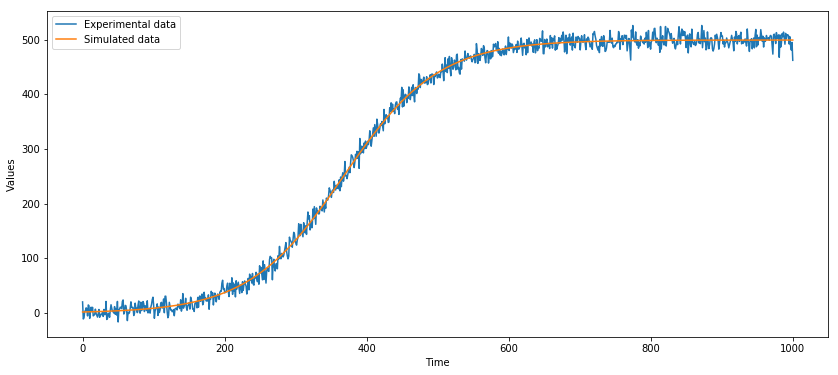

In [14]:
values2 = model.simulate(found_parameters, times)

plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Experimental data')
plt.plot(times, values2, label='Simulated data')
plt.legend()
plt.show()

## Comparing the solution with the true parameters

Because this was a toy model, we can also compare the parameters with the known true parameters:

In [17]:
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Found solution:          True parameters:
 1.50260358681572701e-02     1.49999999999999994e-02
 4.99041195435776217e+02     5.00000000000000000e+02


So it looks like we were close, but not _exactly_ at the right parameters.

Why didn't we find _exactly_ the right solution?

To investigate this, we start by looking at the error measure, evaluated at the true solution and at the obtained solution:

In [18]:
print('Error at obtained solution: ')
print(error(found_parameters))

print('Error at true solution: ')
print(error(real_parameters))

Error at obtained solution: 
103600.65431698953
Error at true solution: 
104075.38815545432


Another way to compare them is to plot the error function on a line drawn between these points:

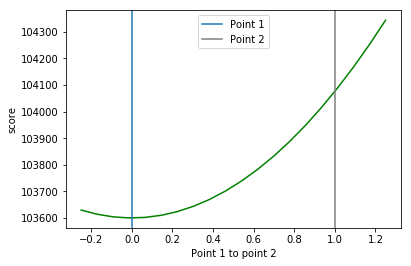

In [19]:
import pints.plot
fig, axes = pints.plot.function_between_points(error, point_1=found_parameters, point_2=real_parameters)
axes.set_ylabel('score')
plt.show()

So it looks like we found a solution that's slightly _better_ than the true solution - how can that be?

The answer comes from the noise we added to our data, which introduced a _bias_ in the obtained results.
We can see this by looking at the noise itself:

In [22]:
noise = values - model.simulate(real_parameters, times)
print(np.mean(noise))

-0.3377231356892277


So when we added this noise to our simulated trace, it caused a slight vertical shift in the data.
And when we optimised to that shifted data, the optimiser found model parameters that could compensate for this shift.

We can see this by inspecting the mean of the _estimated noise_:

In [24]:
noise = values - model.simulate(found_parameters, times)
print(np.mean(noise))

-0.11355918759472577


So it seems the final error is a result of our data including a finite sample of noise from a Gaussian distribution, which has some non-zero offset, i.e. the [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error).
As a result, the effect should scale with $1/\sqrt(n)$, where $n$ is the number of sample points in the data.
We can try this out for a few points:

In [84]:
# Lists for points to plot:
#  x will be the number of points in the data,
#  y will be the distance to the true parameters, as measured with an L2-norm.
x = []
y = []

# Try out an increasing number of points
n_points = [200, 300, 400, 600, 800, 1200, 1600]
repeats = 50

for n in n_points:
    print('Running experiments for ' + str(n) + ' points')

    # And repeat each experiment multiple times, because it's probabilistic!
    for i in range(repeats):

        # Create a new problem, with n time points
        times = np.linspace(0, 1000, n)
        noise = np.random.normal(size=n) * 10
        values = model.simulate(real_parameters, times) + noise
        problem = pints.SingleOutputProblem(model, times, values)
        error = pints.SumOfSquaresError(problem)

        # Find a solution
        # We'll use an OptimisationController, so that we can disable logging output
        opt = pints.OptimisationController(error, x0, boundaries=boundaries, method=pints.XNES)
        opt.set_log_to_screen(False)    
        found_parameters, found_value = opt.run()

        # Calculate and the distance from the true parameters to the obtained ones
        d = real_parameters - found_parameters
        
        # Scale by the true parameters
        d / real_parameters
        
        # Calculate distance
        d = np.sqrt(np.sum(d**2))

        # Store points for plotting
        x.append(n)
        y.append(d)


Running experiments for 200 points
Running experiments for 300 points
Running experiments for 400 points
Running experiments for 600 points
Running experiments for 800 points
Running experiments for 1200 points
Running experiments for 1600 points


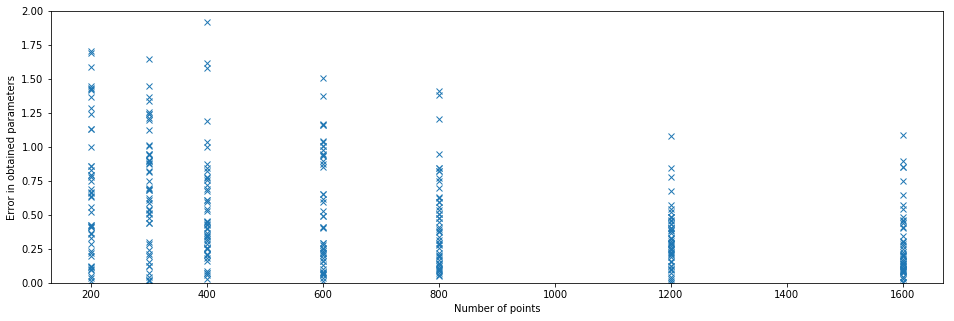

In [85]:
# Create a figure
# To remove (large) outliers, we set a limit on the y-axis scale
plt.figure(figsize=(16, 5))
plt.xlabel('Number of points')
plt.ylabel('Error in obtained parameters')
plt.plot(x, y, 'x')
plt.ylim(0, 2)
plt.show()

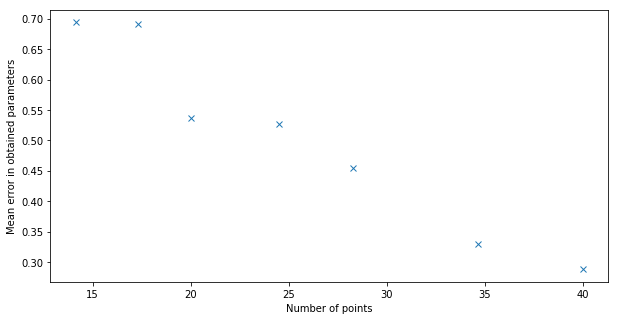

In [86]:
averages = []
for i, n in enumerate(n_points):
    errors = np.array(y[i * repeats:(i + 1) * repeats])
    errors = errors[errors < 2]    
    averages.append(np.mean(errors))

plt.figure(figsize=(10, 5))
plt.xlabel('Number of points')
plt.ylabel('Mean error in obtained parameters')
plt.plot(np.sqrt(n_points), averages, 'x')
plt.show()